In [1]:
original_stats = {
    "Dataset1": {"ll" : -1.0903135560503194, "meu" : 1922639.5, 'nodes' : 22},
    "Dataset2": {"ll" : -1.1461735112245122, "meu" : 54.92189449375, 'nodes' : 51},
    "Dataset3": {"ll" : -1.3292497032277288, "meu" : 3.11376125, 'nodes' : 49},
    "Dataset4": {"ll" : -0.5943350928785097, "meu" : 42.60624317138454, 'nodes' : 125},
    "Dataset5": {"ll" : -0.8912294493362266, "meu" : 242.863042737567, 'nodes' : 50},
    "Dataset6": {"ll" : -1.8151637099020188, "meu" : -2803562.5, 'nodes' : 45}
}




Export_Textiles



Done


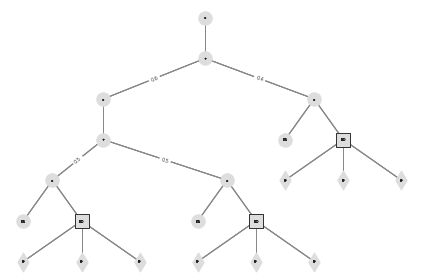

In [2]:


import numpy as np

import logging
logger = logging.getLogger(__name__)


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from os import path as pth
import sys, os
import random

from sklearn.model_selection import train_test_split
from spn.data.metaData import *
from spn.structure.StatisticalTypes import MetaType
from spn.algorithms.SPMNDataUtil import align_data
from spn.algorithms.SPMN import SPMN
from spn.algorithms.MEU import meu
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.Statistics import get_structure_stats_dict
from spn.io.Graphics import plot_spn
from spn.data.simulator import get_env
from spn.algorithms.MEU import best_next_decision

import matplotlib.pyplot as plt
from os import path as pth
import sys, os

datasets = ['Export_Textiles', 'HIV_Screening', 'Computer_Diagnostician', 'Powerplant_Airpollution', 'Test_Strep', 'LungCancer_Staging']
datasets = ['Export_Textiles']

path = "original_new"



for dataset in datasets:
	
	print(f"\n\n\n{dataset}\n\n\n")
	plot_path = f"{path}/{dataset}"
	if not pth.exists(plot_path):
		try:
			os.makedirs(plot_path)
		except OSError:
			print ("Creation of the directory %s failed" % plot_path)
			sys.exit()


	partial_order = get_partial_order(dataset)
	utility_node = get_utilityNode(dataset)
	decision_nodes = get_decNode(dataset)
	feature_names = get_feature_names(dataset)
	feature_labels = get_feature_labels(dataset)
	meta_types = [MetaType.DISCRETE]*(len(feature_names)-1)+[MetaType.UTILITY]

			
	df = pd.read_csv(f"spn/data/{dataset}/{dataset}_new.tsv", sep='\t')

	df, column_titles = align_data(df, partial_order)  # aligns data in partial order sequence
	'''
	col_ind = column_titles.index(utility_node[0]) 
	df_without_utility = df1.drop(df1.columns[col_ind], axis=1)
	from sklearn.preprocessing import LabelEncoder
	# transform categorical string values to categorical numerical values
	df_without_utility_categorical = df_without_utility.apply(LabelEncoder().fit_transform)  
	df_utility = df1.iloc[:, col_ind]
	df = pd.concat([df_without_utility_categorical, df_utility], axis=1, sort=False)
	'''
	data = df.values
	train, test = train_test_split(data, test_size=0.2, shuffle=True)
	test = test[:10]

	
	spmn = SPMN(partial_order , decision_nodes, utility_node, feature_names, meta_types, cluster_by_curr_information_set = True, util_to_bin = False)
	spmn = spmn.learn_spmn(train)
	print("Done")
	
	
	nodes = get_structure_stats_dict(spmn)["nodes"]
	
	plot_spn(spmn, f'{path}/{dataset}/spmn.pdf', feature_labels=feature_labels)



	
	total_ll = 0
	for instance in test:
		test_data = np.array(instance).reshape(-1, len(feature_names))
		total_ll += log_likelihood(spmn, test_data)[0][0]
	ll = (total_ll/len(test))


	test_data = [[np.nan]*len(feature_names)]
	m = meu(spmn, test_data)
	meus = (m[0])



In [6]:

    env = get_env(dataset)
    total_reward = 0
    trials = 1000
    batch_size = trials / 10
    batch = list()

    for z in range(trials):

        state = env.reset()  #
        while(True):
            output = best_next_decision(spmn, state)
            #output = spmn_topdowntraversal_and_bestdecisions(spmn, test_data)
            action = output[0][0]
            state, reward, done = env.step(action)
            if done:
                total_reward += reward
                break
        if (z+1) % batch_size == 0:
            batch.append(total_reward/batch_size)
            total_reward = 0

    avg_rewards = np.mean(batch)
    reward_dev = np.std(batch)

    print(f"\n\tLog Likelihood : {ll}")
    print(f"\n\tMEU : {meus}")
    print(f"\n\tNodes : {nodes}")
    print(f"\n\tAverage rewards : {avg_rewards}")
    print(f"\n\t\tDeviation : {reward_dev}")


    f = open(f"{path}/{dataset}/stats.txt", "w")
    f.write(f"\n{dataset}")
    f.write(f"\n\tLog Likelihood : {ll}")
    f.write(f"\n\tMEU : {meus}")
    f.write(f"\n\tNodes : {nodes}")
    f.write(f"\n\tAverage rewards : {avg_rewards}")
    f.write(f"\n\t\tDeviation : {reward_dev}")
    f.close()


	Log Likelihood : -1.1730840700517409

	MEU : 1919486.325

	Nodes : 22

	Average rewards : 1709653.0

		Deviation : 37257.301445488505
